# Проект 'Телеком'

**Описание проекта**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

<h3>План</h3>

1. Изучить и предобработать данные.
2. Провести исследовательский анализ данных
3. Создать и обучить модели: подготовить признаки, обучить несколько моделей, для лучших подобрать параметры по сетке
4. Протестировать модели: протестировать лучшие модели и выбрать лучшую для дальнейшего внедрения в прод
5. Сформировать рекомендации по внедрению промокодов на основе результатов

<h3>Вопросы</h3>

1. Какую выбрать целевую метрику?
2. Какого показателя целевой метрики нужно добиться?
3. Можно ли извлечь из целевого признака полезные фичи, не допустив утечки информации?

### Первичный осмотр и предобработка

**Импортируем библиотеки и данные**

In [1]:
!pip install shap

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('deep')

from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

from tqdm import notebook
import shap


PATH = '/datasets/final_provider/'
LAST_DATE = '2020-02-01'
RS = 12345

In [3]:
try:
    contract = pd.read_csv('contract.csv')
    internet = pd.read_csv('internet.csv')
    personal = pd.read_csv('personal.csv')
    phone = pd.read_csv('phone.csv')
except:
    contract = pd.read_csv(PATH + 'contract.csv')
    internet = pd.read_csv(PATH + 'internet.csv')
    personal = pd.read_csv(PATH + 'personal.csv')
    phone = pd.read_csv(PATH + 'phone.csv')

**Соединим таблицы в одну**

In [4]:
df_full = (contract
      .merge(personal, on='customerID', how='left')
      .merge(phone, on='customerID', how='left')
      .merge(internet, on='customerID', how='left'))

**Осмотрим данные**

In [5]:
display(df_full.info(), df_full.head(), 'Процент пропусков:', (df_full.isna().sum() / df_full.count()).sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


'Процент пропусков:'

StreamingMovies     0.276600
StreamingTV         0.276600
TechSupport         0.276600
DeviceProtection    0.276600
OnlineBackup        0.276600
OnlineSecurity      0.276600
InternetService     0.276600
MultipleLines       0.107216
BeginDate           0.000000
Dependents          0.000000
customerID          0.000000
SeniorCitizen       0.000000
gender              0.000000
TotalCharges        0.000000
MonthlyCharges      0.000000
PaymentMethod       0.000000
PaperlessBilling    0.000000
Type                0.000000
EndDate             0.000000
Partner             0.000000
dtype: float64

**Заменим названия колонок**

In [6]:
df_full.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
         'senior_citizen', 'partner', 'dependents', 'multiple_lines',
         'internet_service', 'online_security', 'online_backup', 'device_protection',
         'tech_support', 'streaming_tv', 'streaming_movies']

**Проверим данные на дубликаты**

In [7]:
print('Грубых дубликатов:', df_full['customer_id'].duplicated().sum(), '\nДубликатов в id пользователей:', df_full.duplicated().sum())

Грубых дубликатов: 0 
Дубликатов в id пользователей: 0


Посмотрим на уникальные значения категориальных колонок

In [8]:
for column in ['type', 'paperless_billing', 'payment_method', 'gender',
         'senior_citizen', 'partner', 'dependents', 'multiple_lines',
         'internet_service', 'online_security', 'online_backup', 'device_protection',
         'tech_support', 'streaming_tv', 'streaming_movies']:
    print(f'{column}:', df_full[column].unique())

type: ['Month-to-month' 'One year' 'Two year']
paperless_billing: ['Yes' 'No']
payment_method: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
gender: ['Female' 'Male']
senior_citizen: [0 1]
partner: ['Yes' 'No']
dependents: ['No' 'Yes']
multiple_lines: [nan 'No' 'Yes']
internet_service: ['DSL' 'Fiber optic' nan]
online_security: ['No' 'Yes' nan]
online_backup: ['Yes' 'No' nan]
device_protection: ['No' 'Yes' nan]
tech_support: ['No' 'Yes' nan]
streaming_tv: ['No' 'Yes' nan]
streaming_movies: ['No' 'Yes' nan]


**Заполним пропуски** на no_service т.к. при соединении образовались пропуски у клиентов с 1 категорией услуг(либо телфон либо интернет)

In [9]:
df_full = df_full.fillna('no_service')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     7043 non-null   object 
 13  internet_service   7043 non-null   object 
 14  online_security    7043 non-null   object 
 15  online_backup      7043 non-null   object 
 16  device_protection  7043 

Проверим есть ли клиенты без подключенных услуг

In [10]:
df_full[(df_full['internet_service'] == 'no_service') & (df_full['multiple_lines'] == 'no_service')]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies


Все хорошо, можно идти дальше

**Создадим целевой признак**

In [11]:
df_full['churn'] = df_full['end_date'].apply([lambda x: 0 if x == 'No' else 1])

**Изменим типы данных на корректные**

Проверим если записи в день окончания сбора данных

In [12]:
df_full[df_full['end_date'] == LAST_DATE]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,churn


Никто не уходил в этот день, проверим есть ли новые пользователи

In [13]:
df_full[df_full['begin_date'] == LAST_DATE]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,churn
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,Yes,no_service,DSL,Yes,No,Yes,Yes,Yes,No,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,...,Yes,No,no_service,no_service,no_service,no_service,no_service,no_service,no_service,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,...,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,...,Yes,Yes,no_service,no_service,no_service,no_service,no_service,no_service,no_service,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,...,Yes,no_service,DSL,Yes,Yes,Yes,Yes,Yes,No,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,...,Yes,No,no_service,no_service,no_service,no_service,no_service,no_service,no_service,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,...,Yes,Yes,no_service,no_service,no_service,no_service,no_service,no_service,no_service,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,...,Yes,No,no_service,no_service,no_service,no_service,no_service,no_service,no_service,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,...,Yes,No,no_service,no_service,no_service,no_service,no_service,no_service,no_service,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,...,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,0


Эти клиенты не несут информативной нагрузки т.к. оплату они не производили, удалим эти строки

In [14]:
print('Строк до удаления:', len(df_full))
df_full = df_full.drop(df_full[df_full['begin_date'] == LAST_DATE].index, axis=0)
print('Строк после удаления:', len(df_full))

Строк до удаления: 7043
Строк после удаления: 7032


In [15]:
df_full['begin_date'] = pd.to_datetime(df_full['begin_date'], format='%Y-%m-%d')
df_full['end_date'] = pd.to_datetime(df_full['end_date'].replace({'No': LAST_DATE}), format='%Y-%m-%d')
df_full['total_charges'] = df_full['total_charges'].astype('float')

df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  multiple_lines     7032 non-null   object        
 13  internet_service   7032 non-null   object        
 14  online_s

Осмотрим получившийся результат

In [16]:
df_full.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,churn
4859,8041-TMEID,2014-11-01,2020-02-01,Two year,No,Credit card (automatic),108.50,6991.90,Male,1,...,No,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,0
5475,1114-CENIM,2015-04-01,2019-10-01,Month-to-month,Yes,Credit card (automatic),55.00,3092.65,Male,0,...,Yes,Yes,DSL,No,Yes,No,No,No,No,1
6662,6810-VCAEX,2016-03-01,2020-02-01,One year,No,Credit card (automatic),39.65,1798.65,Female,0,...,No,no_service,DSL,Yes,Yes,No,Yes,No,No,0
3485,6221-AVQYL,2019-11-01,2020-01-01,Month-to-month,Yes,Credit card (automatic),73.25,131.05,Male,0,...,No,Yes,Fiber optic,No,No,No,No,No,No,1
1936,2239-CGBUZ,2015-11-01,2020-02-01,One year,Yes,Bank transfer (automatic),60.50,3145.15,Female,0,...,No,No,DSL,Yes,Yes,No,Yes,No,No,0


Создадим признак с временем жизни клиента

In [17]:
df_full['duration'] = (df_full.end_date - df_full.begin_date).dt.days
df_full.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,churn,duration
1251,7595-EUIVN,2019-10-01,2019-11-01,Month-to-month,No,Electronic check,75.80,75.80,Female,0,...,No,Fiber optic,No,Yes,No,No,No,No,1,31
5132,3850-OKINF,2014-03-01,2020-02-01,One year,Yes,Electronic check,66.20,4692.55,Male,0,...,Yes,DSL,Yes,No,No,No,Yes,No,0,2163
2588,5780-INQIK,2019-06-01,2020-02-01,Month-to-month,No,Electronic check,49.40,408.25,Female,0,...,No,DSL,No,No,No,Yes,No,No,0,245
2552,3547-LQRIK,2016-03-01,2020-02-01,One year,No,Electronic check,26.90,1250.85,Female,0,...,Yes,no_service,no_service,no_service,no_service,no_service,no_service,no_service,0,1432
6204,3058-WQDRE,2019-01-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),25.15,331.85,Male,0,...,no_service,DSL,No,No,No,No,No,No,0,396


Отлично, можно переходить к исследовательскому анализу данных и подготовке признаков

### Исследовательский анализ данных

Проверим баланс классов в нашей выборке

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


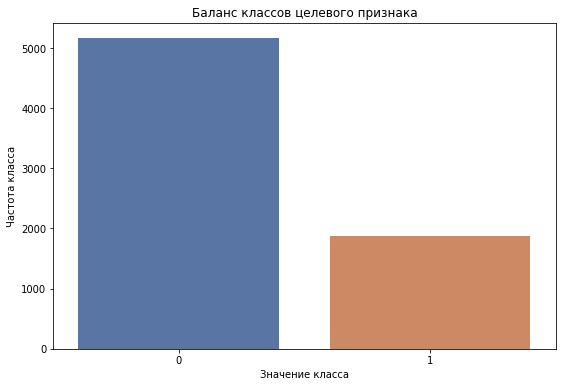

In [18]:
plt.figure(figsize=(9, 6))
sns.countplot(df_full['churn'])

plt.title('Баланс классов целевого признака')
plt.xlabel('Значение класса')
plt.ylabel('Частота класса')
plt.show()

Мы видим явный дисбаланс в пользу подключенных клиентов

Посмотрим как приходили и уходили клиенты с течением времени

Text(0.5, 0.98, 'Распределение прихода и ухода клиентов по времени')

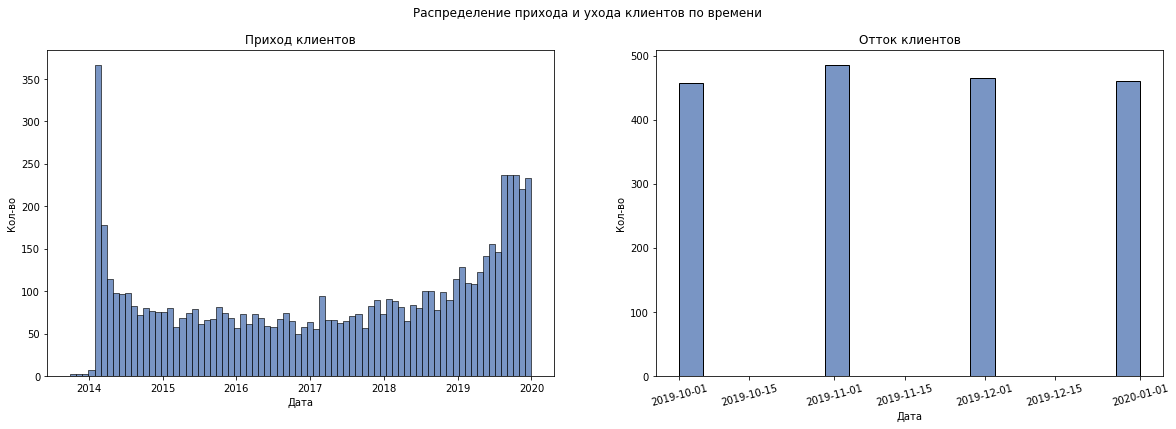

In [19]:
f, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.histplot(df_full['begin_date'], bins=len(pd.to_datetime(df_full['begin_date'], format='%Y-%m').value_counts()), ax=axes[0])
axes[0].set_title('Приход клиентов')
axes[0].set_ylabel('Кол-во')
axes[0].set_xlabel('Дата')

sns.histplot(df_full[df_full['end_date'] != LAST_DATE]['end_date'], ax=axes[1])
axes[1].set_title('Отток клиентов')
axes[1].set_ylabel('Кол-во')
axes[1].set_xlabel('Дата')
plt.xticks(rotation=15)

plt.suptitle('Распределение прихода и ухода клиентов по времени')

Мы видим что скорее всего в 2013 году был запуск компании, а в начале 2014 была обширная рекламная компания по привлечению клиентов которая выражается максимальным пиком. После чего, в течении 3 месяцев вышли на плато вплоть до 2019 года, в котором мы видим быстрые темпы роста числа подключаемых клиентов. На графике с оттоком мы видим что клиенты уходили последние четыре месяца, в те месяцы в которые был самый большой прирост новых клиентов. Проверим откуда происходит отток, из числа новых клинтов, привлекаемых последние четыре месяца или из числа старых клиентов

In [20]:
print('Распределение клиентов пришедших после 2019-10-01\n', df_full[df_full['begin_date'] >= '2019-10-01']['churn'].value_counts(),
      '\nРаспределение клиентов пришедших до 2019-10-01\n', df_full[df_full['begin_date'] <= '2019-10-01']['churn'].value_counts())

Распределение клиентов пришедших после 2019-10-01
 0    547
1    380
Name: churn, dtype: int64 
Распределение клиентов пришедших до 2019-10-01
 0    4709
1    1633
Name: churn, dtype: int64


Видно что процент оттока среди новых клиентов больше, но основную часть ушедших составляют именно старые клиенты

Попытаемся найти с чем это связанно, посмотрим как менялась медиана ежемесячного платежа

Text(0.5, 0, 'Дата')

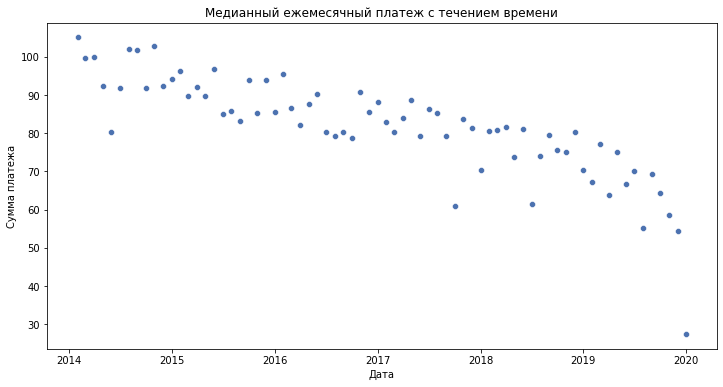

In [21]:
f, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=df_full[df_full['type'] == 'Month-to-month'].groupby('begin_date')[['begin_date', 'monthly_charges']].median(), x='begin_date', y='monthly_charges', ax=ax)
plt.title('Медианный ежемесячный платеж с течением времени')
plt.ylabel('Сумма платежа')
plt.xlabel('Дата')

Как мы видим, ежемесячный платеж клинтов падает, возможно это связано с переходами от ежемесячного платежа к более выгодным тарифам.

Проверим, действительно ли они выгоднее?

In [22]:
df_full.groupby(by='type').median()['monthly_charges']

type
Month-to-month    73.25
One year          68.75
Two year          64.45
Name: monthly_charges, dtype: float64

Да, как мы видим платежи раз в год или два действительно выгодней. Изучим типы оплаты поподробнее

Напишем функцию для визуального осмотра данных

In [23]:
def violinplot_subplot(x_ax, title):
    """Функция вызывающая 4 гафика:
    - распределение ежемесячных платежей
    - распределение суммы платежей
    - распределение времени жизни клиента 
    - распределение клиентов на оставшихся и ушедших

    Args:
        x_ax ([object]): имя столбца для оси x
        title ([object]): заголовок таблицы
    """
    f, axes = plt.subplots(1, 4, figsize=(25, 5))

    sns.violinplot(data=df_full, x=x_ax, y="monthly_charges", hue="churn",
                split=True, inner="quart", linewidth=1, ax=axes[0])
    plt.setp(axes[0].get_xticklabels(), rotation=15, horizontalalignment='right')
    axes[0].set_ylabel('Ежемесячные платежи')
    axes[0].legend(handles=axes[0].legend_.legendHandles, labels=['Остались', 'Ушли'])

    sns.violinplot(data=df_full, x=x_ax, y="total_charges", hue="churn",
                split=True, inner="quart", linewidth=1, ax=axes[1])
    plt.setp(axes[1].get_xticklabels(), rotation=15, horizontalalignment='right')
    axes[1].set_ylabel('Сумма платежей')
    axes[1].legend(handles=axes[1].legend_.legendHandles, labels=['Остались', 'Ушли'])

    sns.violinplot(data=df_full, x=x_ax, y="duration", hue="churn",
                split=True, inner="quart", linewidth=1, ax=axes[2])
    plt.setp(axes[2].get_xticklabels(), rotation=15, horizontalalignment='right')
    axes[2].set_ylabel('Время жизни клиента')
    axes[2].legend(handles=axes[2].legend_.legendHandles, labels=['Остались', 'Ушли'])

    sns.countplot(x=x_ax, hue="churn", data=df_full, ax=axes[3])
    axes[3].legend(['Остались', 'Ушли'])
    axes[3].set_ylabel('Кол-во клиентов')
    plt.setp(axes[3].get_xticklabels(), rotation=15, horizontalalignment='right')
    
    plt.suptitle(title)

Осмотрим данные по типу оплаты

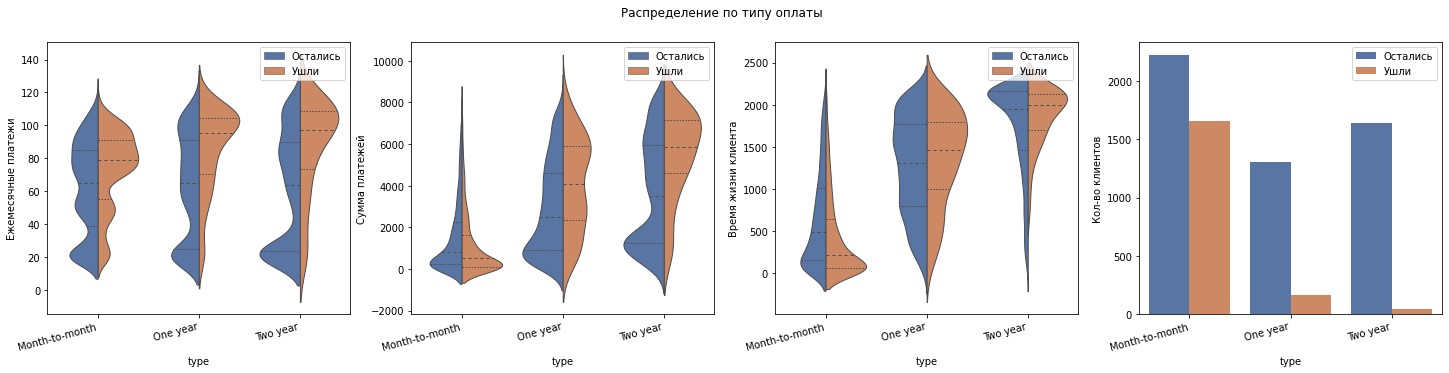

In [24]:
violinplot_subplot('type', 'Распределение по типу оплаты')

Из графиков мы видим, что:
- Большинство ушедших клиентов производили оплату раз в месяц
- Медианное время жизни клиентов с ежемесячной оплатой примерно 200-300 дней, а у клиентов с ежегодной оплатой и раз в два года 1500-2000 дней
- Медиана платежей ушедших клиентов больше медианы оставшихся во всех типах оплаты

Осмотрим данные по методу оплаты

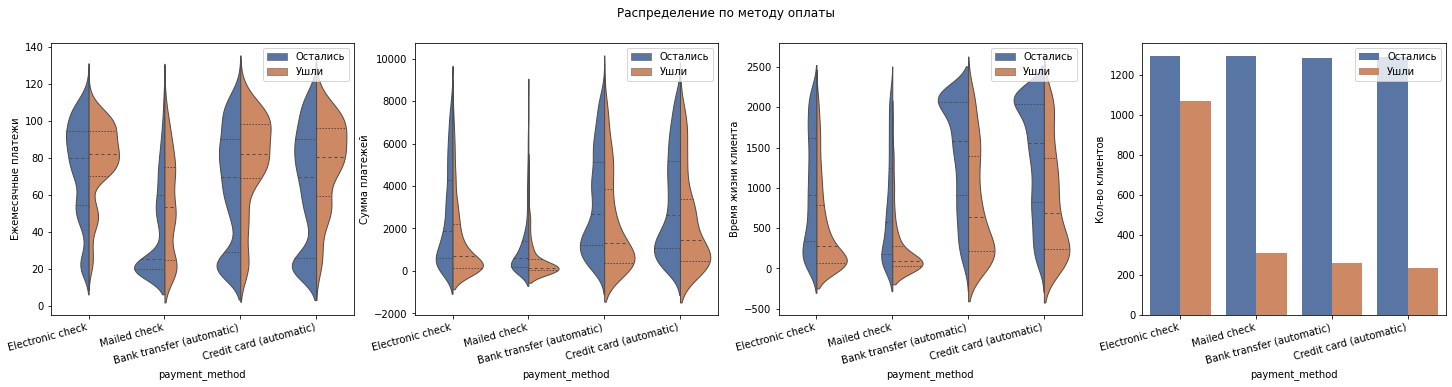

In [25]:
violinplot_subplot('payment_method', 'Распределение по методу оплаты')

- Большинство ушедших клиентов пользовались электронным чеком
- У клиентов с автоплатежами значительно больше время жизни

Осмотрим наличие электронного счета

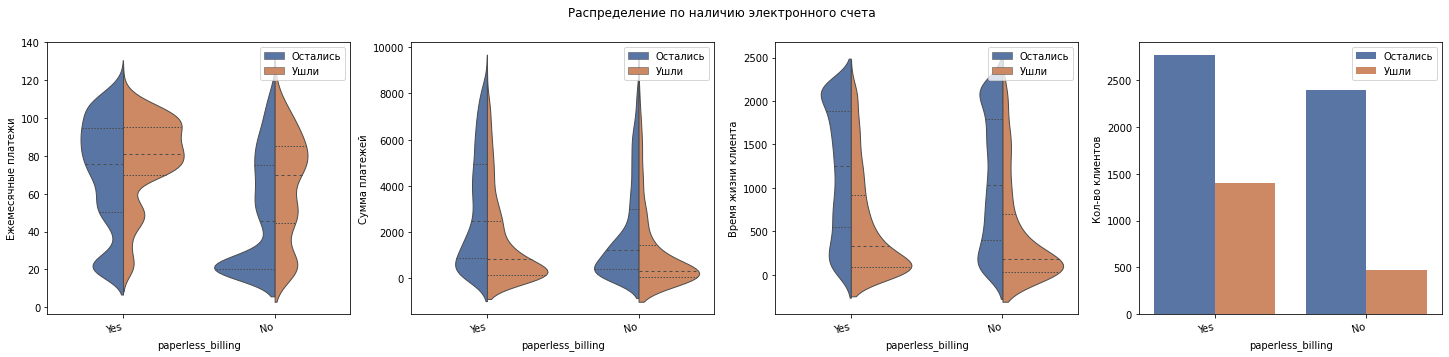

In [26]:
violinplot_subplot('paperless_billing', 'Распределение по наличию электронного счета')

- У большей части ушедших клиентов был электронный счет

Осмотрим данные о клиентах

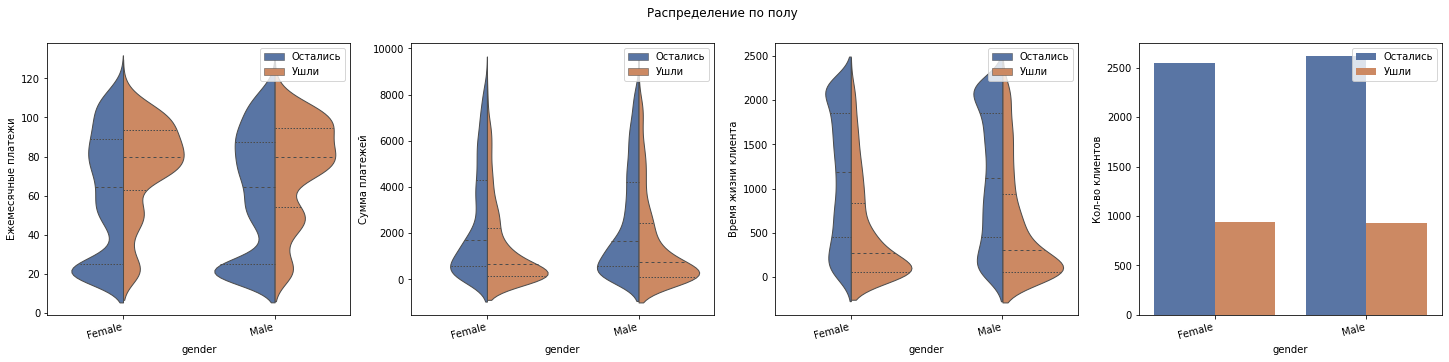

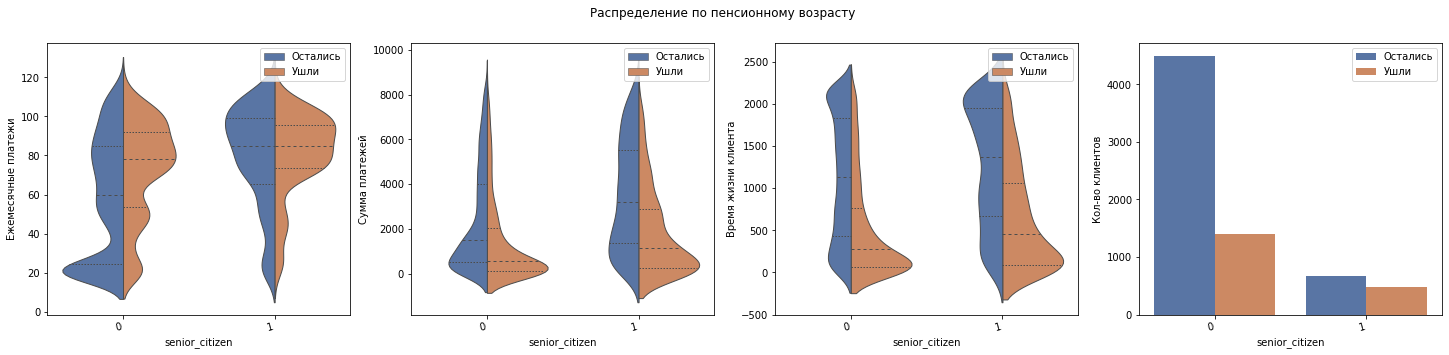

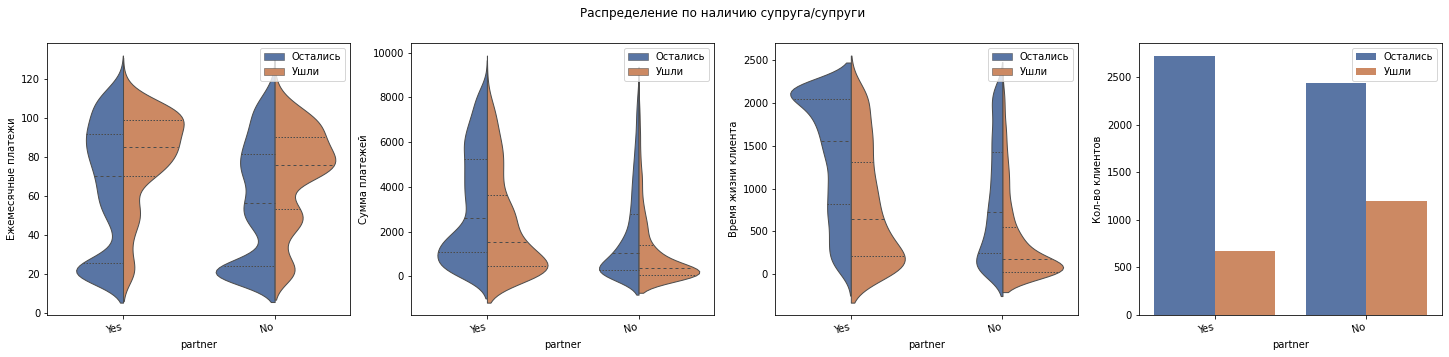

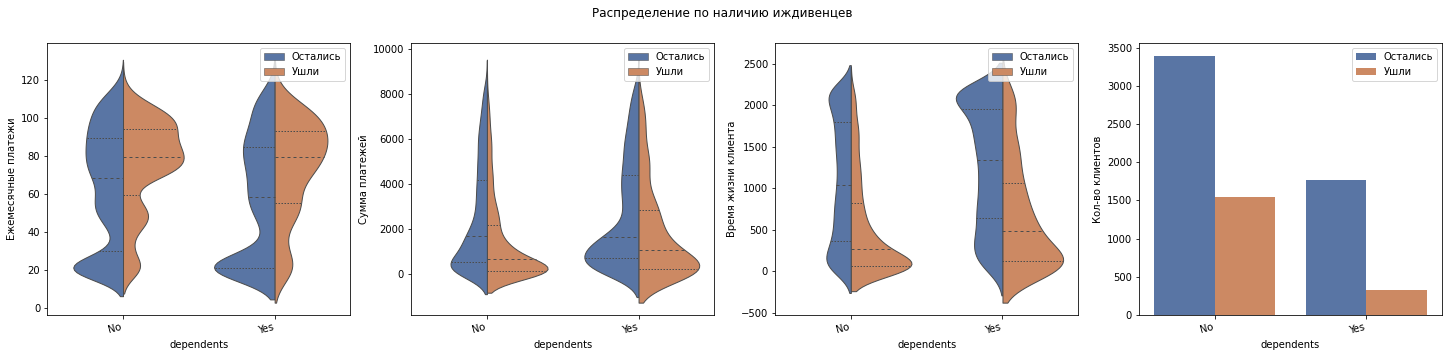

In [27]:
d_client = {'gender': 'Распределение по полу',
            'senior_citizen': 'Распределение по пенсионному возрасту',
            'partner': 'Распределение по наличию супруга/супруги',
            'dependents': 'Распределение по наличию иждивенцев'}
for key, value in d_client.items():
    violinplot_subplot(key, value)

- В графике с полом нет видимых различий, колонка не информативна
- Среди клиентов пенсионного возраста почти половина уходит, при этом медиана платежей ушедших пенсионеров и оставшихся равны, в то время как у людей не пенсионного возраста медиана ушедших значительно выше чем у оставшихся. Так же время жизни клиента у пенсионеров выше чем у клиентов не пенсионного возраста. Возможно отток связан с естественными причинами
- Среди холостых клинтов наблюдается больший отток, так же у клиентов в браке большее время жизни и больше медиана в ежемесячной плате
- Наблюдается больший отток среди клиентов без детей, так же у них меньшее время жизни. При этом платежеспособность клиентов с детьми и без примерно одинаковая

Посмотрим на данные о нескольких телефонных линиях

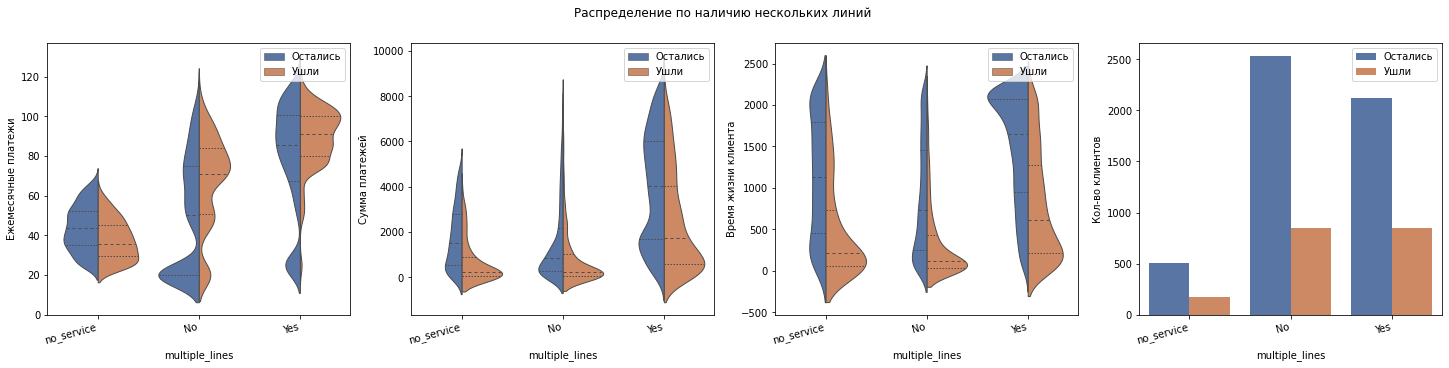

In [28]:
violinplot_subplot('multiple_lines', 'Распределение по наличию нескольких линий') 

- Отток клиентов с услугой и без примерно одинаковый, при этом время жизни клиентов с подключенной услугой значительно выше. Возможно клиенты без услуги не знаю о ее существовании и стоит их проинформировать

Осмотрим данные о интернет услугах

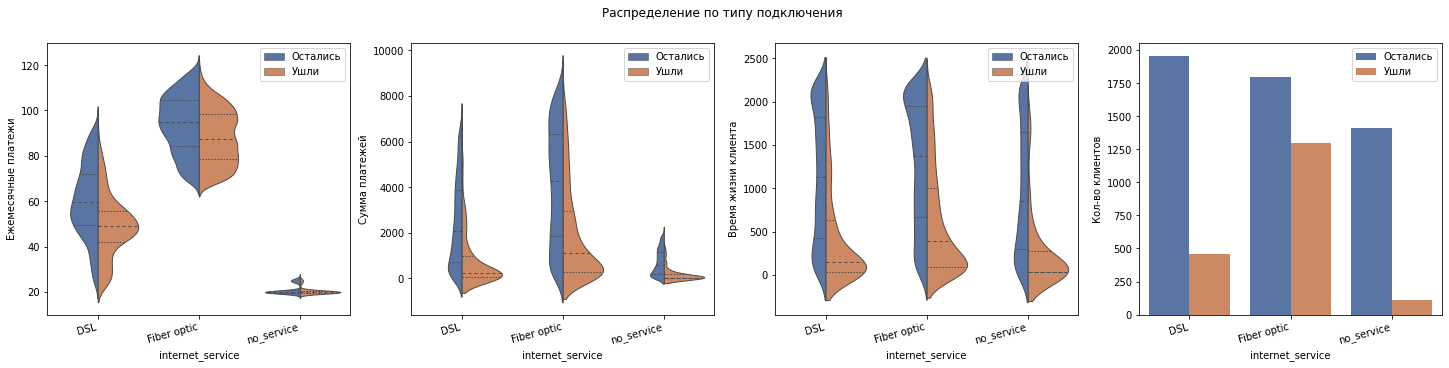

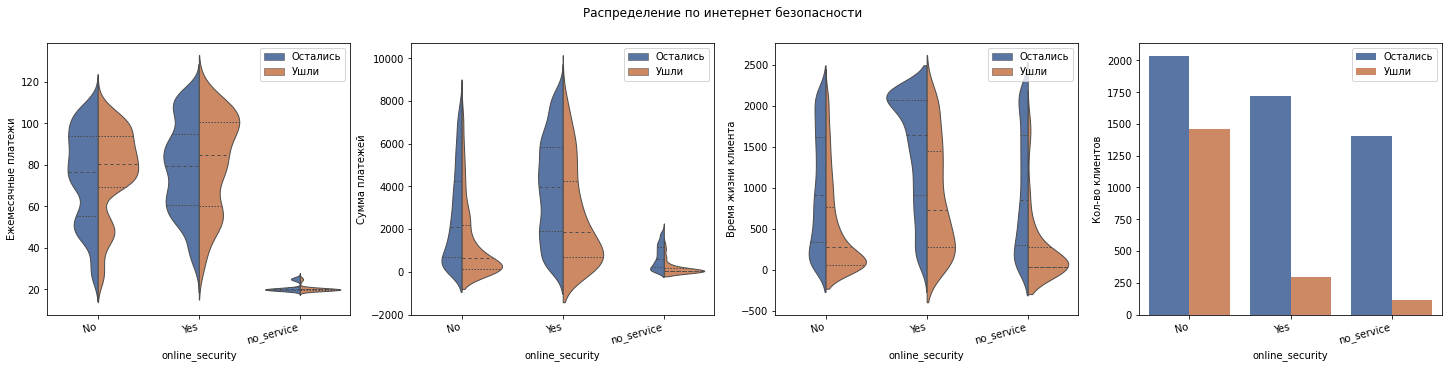

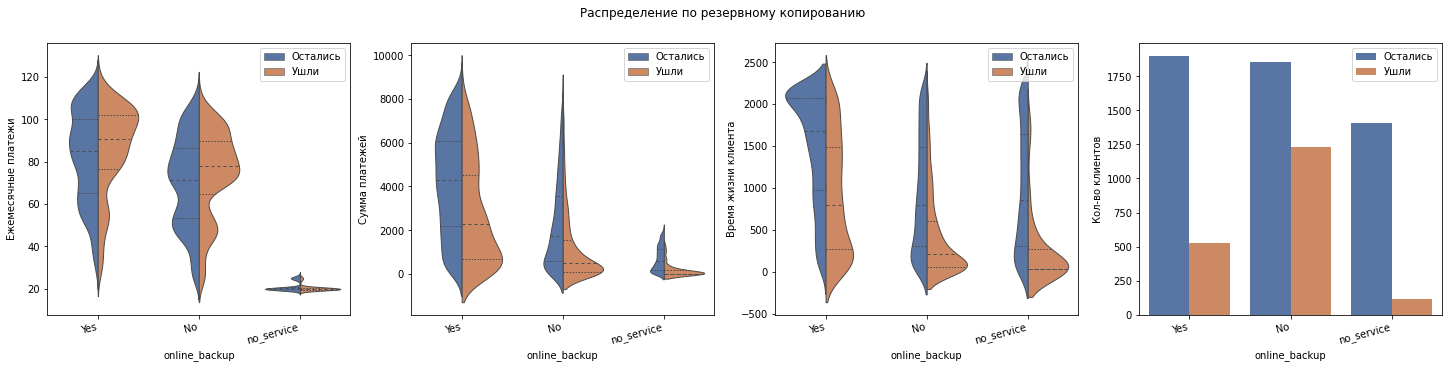

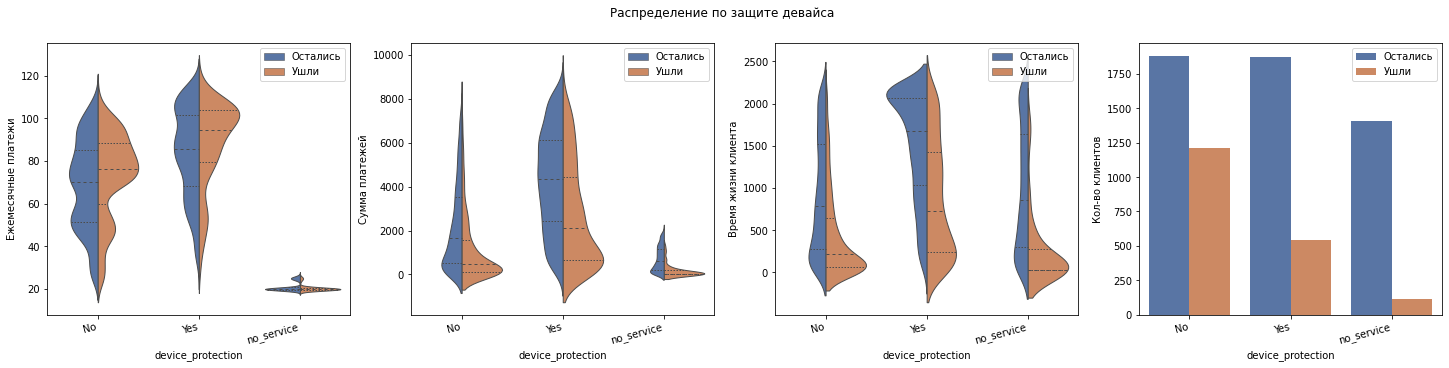

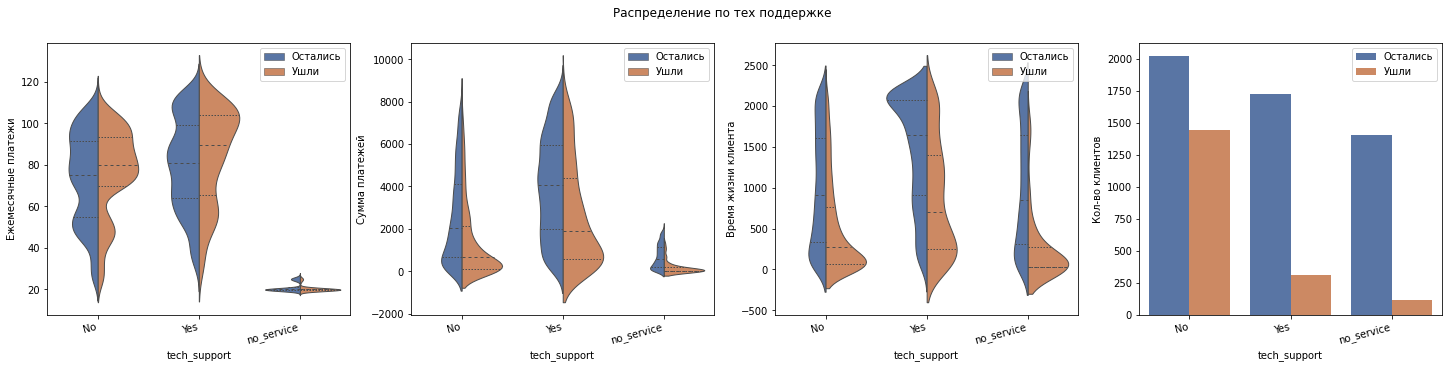

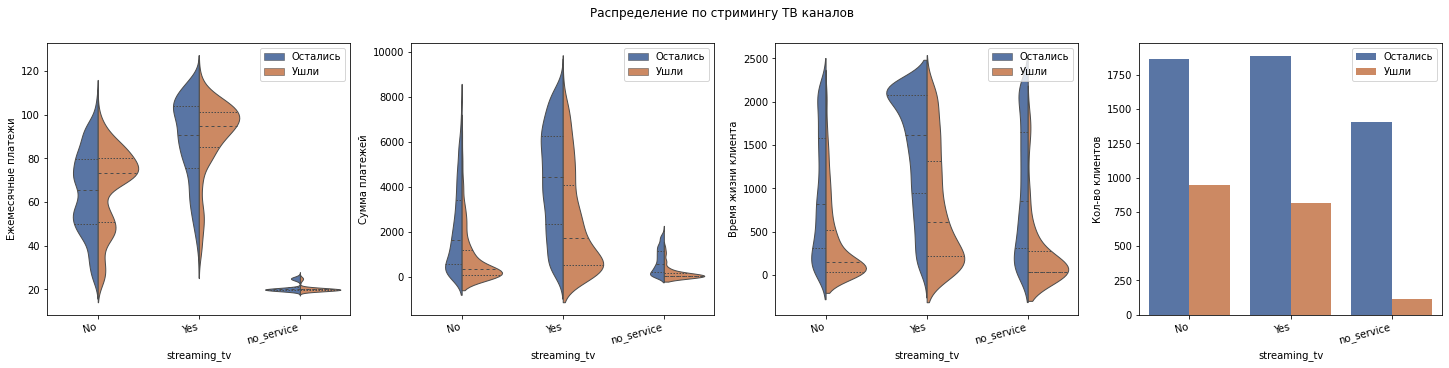

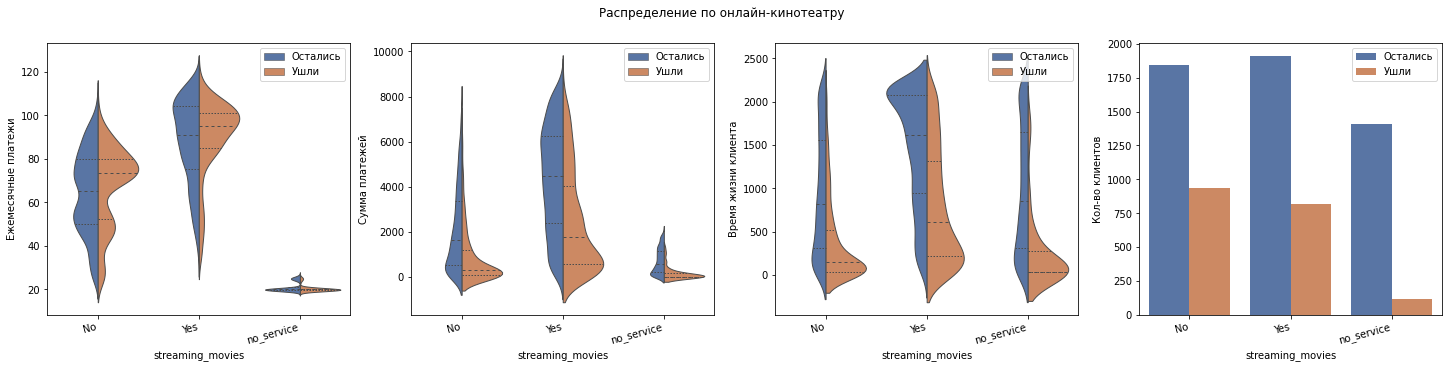

In [29]:
d_client = {'internet_service': 'Распределение по типу подключения',
            'online_security': 'Распределение по инетернет безопасности',
            'online_backup': 'Распределение по резервному копированию',
            'device_protection': 'Распределение по защите девайса',
            'tech_support': 'Распределение по тех поддержке',
            'streaming_tv': 'Распределение по стримингу ТВ каналов',
            'streaming_movies': 'Распределение по онлайн-кинотеатру',}
for key, value in d_client.items():
    violinplot_subplot(key, value)

- У клиентов с оптоволоконным типом подключения наблюдается больший отток, при этом время жизни у них больше. Так же видно что стоимость такого подключения на порядок выше
- У клиентов с услугой интернет безопасности отток гораздо ниже, а также больше продолжительность жизни
- Такая же тенденция у услуг: резервного копирования, защиты девайса и тех.поддержки 
- В услугах стриминга ТВ и фильмов отток примерно одинаковый, но время жизни клиентов с услугой больше

#### Вывод

В результате анализа мы выявили, что:

 - **Данные о приходе-оттоке клиентов:**
   - Активный рост компании был в начале 2014 года, после этого было плато до конца 2019. Последние 4 месяца наблюдался значительный рост(возможно очередная рекламная компания)
   - Отток клиентов произошел именно в эти последние 4 месяца. Отток происходил 1го числа каждого месяца, по всей видимости после окончания месяца оплаты

 - **Данные об оплате:**
   - Медианный показатель ежемесячного чека снижался вплоть до окончания периода сбора информации, скорее всего это связано с переходам на более выгодные тарифы оплаты раз в 1 и 2 года
   - Основной отток клиентов происходит из категории с ежемесячной оплатой. Показатель жизни клиента с оплатой раз в 1 и 2 года в разы превышает время жизни клиентов с помесячной оплатой(200-300 дней против 1500-2000 в медиане). При этом медиана ежемесячной суммы у клиентов с годовыми оплатами выше. Из этого можно сделать вывод что клиенты с годовыми платежами могут позволить себе больше услуг, за ту же или чуть большую сумму. **Стоит предложить клиентам с ежемесячной оплатой переход на более выгодные годовые тарифы**
   - Так же мы видим что медиана ушедших клиентов с годовыми оплатами значительно выше оставшихся, что означает отток клиентов с большим количеством услуг. **Таким клиентам стоит предложить дополнительные промокоды**
   - Мы обнаружили, что отток клинтов на порядок ниже у клиентов с автоматическими методами оплаты, а так же больше время жизни и средний чек. **Стоит отправлять рекомендации клиентам о переходе на автоплатежи**
   - Клиенты с электронным счетом уходят чаще чем без него

 - **Данные о клиентах:**
   - Данные о поле клиента не несут информационной нагрузки
   - Среди пенсионеров почти половина уходит, хотя продолжительность жизни и средний чек выше, при этом медианы среднего чека ушедших и оставшихся равны, это означает, что дело не в деньгах. Скорее всего отток связан с естественными причинами
   - У холостых клиентов без детей наблюдается больший отток, а так же меньшая продолжительность жизни. Так же у клиентов в браке больше средний чек, у клиентов с детьми и без они одинаковы

 - **Данные о телефонных услугах:**
   - Среди клиентов без услуги нескольких линий одинаковый отток, но при этом продолжительность жизни клиентов с услугой на порядок выше. **Стоит проинформировать клиентов без услуги о ее наличии**

 - **Данные о интернет услугах:**
   - У клиентов с оптоволоконным типом подключения больший отток, но большее время жизни. Отток скорее всего связан с ценой на порядок выше альтернативного подключения, но возможен вариант что из за большого числа новых клиентов увеличилась нагрузка и интернет стал медленнее. **Уточнить у тимлида про проблемы с интернетом**
   - У клиентов с услугами интернет безопасности, резервного копирования, защиты девайса и тех.поддержки - отток гораздо ниже, а так же больше продолжительность жизни
   - У клиентов с услугами стриминга ТВ и фильмов отток примерно одинаковый, но продолжительность жизни выше
   - **Так же стоит производить информирование об интернет услугах, в особености о - интернет безопасности, резервном копировании, защиты девайса и тех.поддержки** 

### Подготовка признаков

<AxesSubplot:>

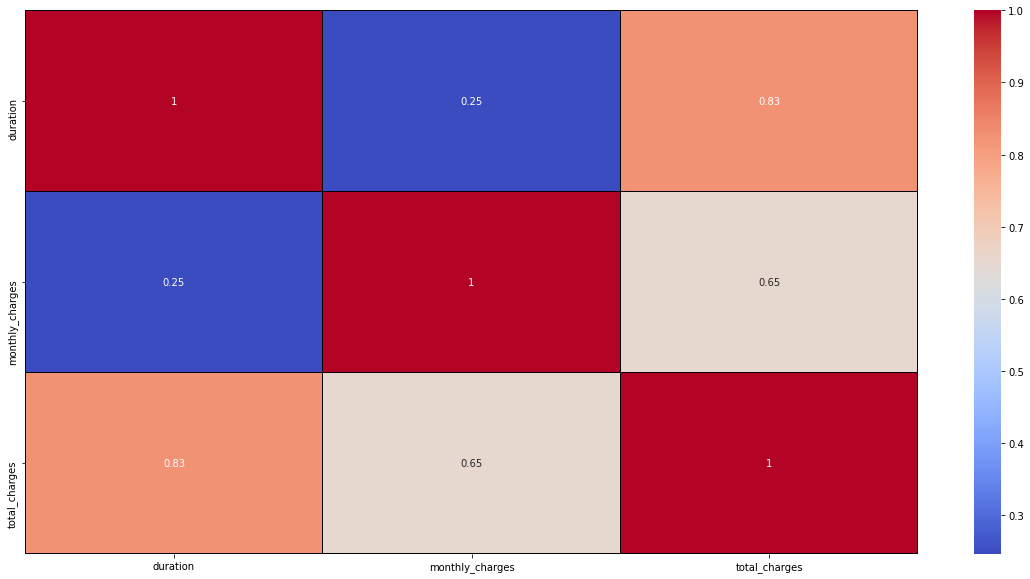

In [30]:
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(abs(df_full[['duration', 'monthly_charges', 'total_charges']].corr()), linewidths=0.01, linecolor='black', annot=True, cmap='coolwarm')

Мы имеем мультиколлинеарность в виде столбца total_charges 

Удалим лишние признаки и разобьем данные на трейн и тест

In [31]:
# Удалим лишние признаки и закодируем категориальные данные
drop_cols = ['customer_id', 'begin_date', 'end_date', 'total_charges', 'churn']

features = pd.get_dummies(df_full.drop(drop_cols, axis=1), drop_first=True)
target = df_full['churn']

# Разобьем на трейн и тест, на тест оставим 20%
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=RS)

### Построение моделей

Создадим пайплайн и обучим базовые модели

  0%|          | 0/4 [00:00<?, ?it/s]

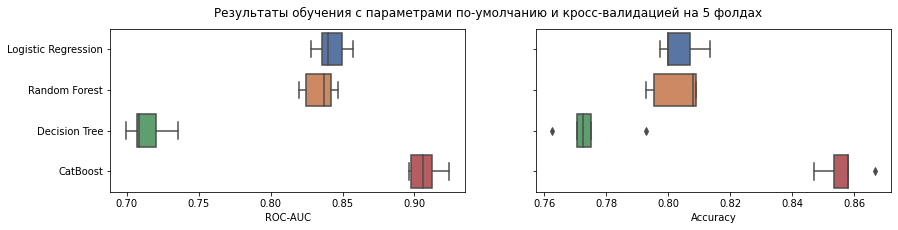

,Обучение (сек),Предсказание (сек),Среднее ROC-AUC на валидации,Среднее Accuracy на валидации
Модель,,,,
CatBoost,9.231649,0.062938,0.907235,0.856533
Logistic Regression,0.147210,0.045924,0.842015,0.803556
Random Forest,0.776565,0.084375,0.833991,0.802844
Decision Tree,0.041887,0.007979,0.714062,0.774756


In [32]:
models = [
    ('Logistic Regression', LogisticRegression(random_state=RS)),
    ('Random Forest', RandomForestClassifier(random_state=RS)),
    ('Decision Tree', DecisionTreeClassifier(random_state=RS)),
    ('CatBoost', CatBoostClassifier(random_state=RS, verbose=100))
]

scoring = ('roc_auc', 'accuracy')
results = pd.DataFrame()
base_data = {'fit_time': [0], 'score_time': [0],
             'test_roc_auc': [0], 'test_accuracy': [0]}

for name, model in notebook.tqdm(models):

    pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
    c_val = cross_validate(pipe, X_train, y_train, scoring=scoring, n_jobs=5)
    c_val.update(model=name)

    results = pd.concat([results, pd.DataFrame(c_val)])

fig, axes = plt.subplots(1, 2, figsize=(14, 3), sharey=True)

sns.boxplot(data=results, y='model', x='test_roc_auc', palette='deep', ax=axes[0])
axes[0].set_xlabel('ROC-AUC')
axes[0].set_ylabel('')

sns.boxplot(data=results, y='model', x='test_accuracy', palette='deep', ax=axes[1])
axes[1].set_xlabel('Accuracy')
axes[1].set_ylabel('')

plt.suptitle(
    'Результаты обучения с параметрами по-умолчанию и кросс-валидацией на 5 фолдах')
plt.show()

results = results.groupby('model').mean().sort_values(
    by='test_roc_auc', ascending=False)
results.index.name = 'Модель'
results.columns = ['Обучение (сек)', 'Предсказание (сек)',
                   'Среднее ROC-AUC на валидации', 'Среднее Accuracy на валидации']
display(results)

У нас с большим отрывом лидирует catboost

Будем использовать в дальнейшем. Изучим модель поподробнее - построим матрицу ошибок, ROC кривую, а так же посчитаем точность и полноту 

Learning rate set to 0.02154
0:	learn: 0.6772764	total: 166ms	remaining: 2m 46s
100:	learn: 0.3840114	total: 539ms	remaining: 4.8s
200:	learn: 0.3555046	total: 792ms	remaining: 3.15s
300:	learn: 0.3383262	total: 1.04s	remaining: 2.41s
400:	learn: 0.3230158	total: 1.32s	remaining: 1.97s
500:	learn: 0.3045055	total: 1.59s	remaining: 1.59s
600:	learn: 0.2876136	total: 1.87s	remaining: 1.24s
700:	learn: 0.2723676	total: 2.19s	remaining: 934ms
800:	learn: 0.2594764	total: 2.46s	remaining: 612ms
900:	learn: 0.2475853	total: 2.72s	remaining: 299ms
999:	learn: 0.2357674	total: 2.97s	remaining: 0us
Модель <catboost.core.CatBoostClassifier object at 0x000002AE5A617C40>
ROC-AUC оценка на тесте: 0.913
Accuracy оценка на тесте: 0.861
Precision (точность): 0.851
Recall (полнота): 0.595


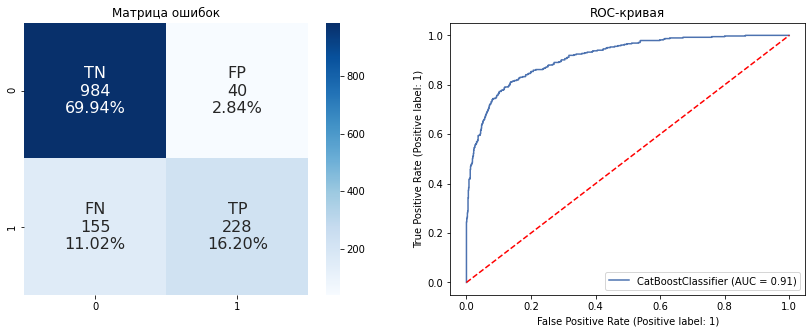

In [33]:
def cf_matrix(target, prediction, ax):
    """Функция для построения матрицы ошибок

    Args:
        target (_type_): Истинные значения
        prediction (_type_): Предсказания
        ax (_type_): Ось
    """
    cf_matrix = confusion_matrix(target, prediction)

    group_names = ['TN', 'FP', 'FN', 'TP']

    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]

    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, fmt='', cmap='Blues', ax=ax,
                annot=labels, annot_kws={'size': 16})

    ax.set_title('Матрица ошибок')


def score_output(model, fit=True):
    """Функция для вывода матрицы ошибок и ROC кривой, а так же информации о метриках

    Args:
        model (_type_): Модель
        fit (bool, optional): Значение отвечающее за обучение модели. Defaults to True.
    """
    if fit:
        model.fit(X_train, y_train)
    predict = model.predict(X_test)
    predict_proba = model.predict_proba(X_test)[:, 1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    cf_matrix(y_test, predict, ax=ax1)
    plot_roc_curve(model, X_test, y_test, ax=ax2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    ax2.set_title('ROC-кривая')
    
    print('Модель', model)
    print('ROC-AUC оценка на тесте: %.3f' % roc_auc_score(y_test, predict_proba))
    print('Accuracy оценка на тесте: %.3f' % accuracy_score(y_test, predict))
    print('Precision (точность): %.3f' % precision_score(y_test, predict))
    print('Recall (полнота): %.3f' % recall_score(y_test, predict))
    
    
score_output(models[3][1])

- Мы видим что 85.1 % из предсказанных клиентов склонны к оттоку
- Мы можем распознать 59.5 % ушедших клиентов 

Посмотрим на важность признаков

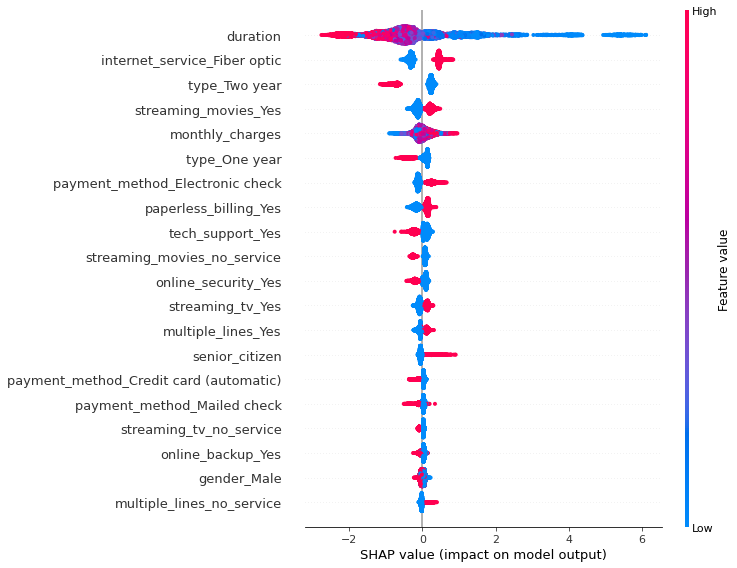

In [34]:
explainer = shap.Explainer(models[3][1])
shap_values = explainer(features)

shap.summary_plot(shap_values, features)

Мы видим что основным признаком является duration 

Оставим лучшие 5 признаков и обучим модель на них

Learning rate set to 0.04855
0:	learn: 0.6598053	test: 0.6597115	best: 0.6597115 (0)	total: 3.52ms	remaining: 3.52s
100:	learn: 0.3648848	test: 0.3766113	best: 0.3766113 (100)	total: 341ms	remaining: 3.04s
200:	learn: 0.3337620	test: 0.3574260	best: 0.3574260 (200)	total: 639ms	remaining: 2.54s
300:	learn: 0.2949907	test: 0.3334619	best: 0.3334619 (300)	total: 956ms	remaining: 2.22s
400:	learn: 0.2669701	test: 0.3174331	best: 0.3174238 (399)	total: 1.31s	remaining: 1.95s
500:	learn: 0.2456470	test: 0.3032460	best: 0.3032460 (500)	total: 1.68s	remaining: 1.68s
600:	learn: 0.2309719	test: 0.2965205	best: 0.2965205 (600)	total: 2.03s	remaining: 1.35s
700:	learn: 0.2188051	test: 0.2916770	best: 0.2916770 (700)	total: 2.34s	remaining: 998ms
800:	learn: 0.2066900	test: 0.2857444	best: 0.2856705 (799)	total: 2.65s	remaining: 659ms
900:	learn: 0.1967483	test: 0.2823627	best: 0.2823627 (900)	total: 2.98s	remaining: 328ms
999:	learn: 0.1890997	test: 0.2798519	best: 0.2798188 (996)	total: 3.33s	r

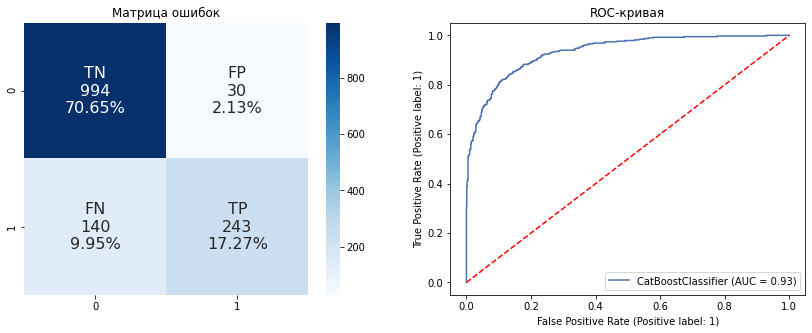

In [35]:
top5_features = ['duration', 'internet_service', 'type', 'streaming_movies', 'monthly_charges']

features_top = pd.get_dummies(df_full[top5_features])

X_train, X_test, y_train, y_test = train_test_split(
    features_top, target, test_size=0.2, random_state=RS)

catboost = CatBoostClassifier(random_state=RS, verbose=100)

catboost.fit(
    X_train, y_train,
    eval_set=(X_test, y_test)
)

score_output(catboost, fit=False)

- Мы видим что 89 % из предсказанных клиентов склонны к оттоку
- Мы можем распознать 63.4 % ушедших клиентов 

Прогоним модель по grid search и попробуем улучшить качество

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=RS)

catboost_gs = CatBoostClassifier(random_state=RS, silent=True)
params = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
catboost_gs.grid_search(params, X=X_train, y=y_train, cv=cv, verbose=False)

Модель <catboost.core.CatBoostClassifier object at 0x000002AE5F17E7F0>
ROC-AUC оценка на тесте: 0.936
Accuracy оценка на тесте: 0.881
Precision (точность): 0.880
Recall (полнота): 0.653


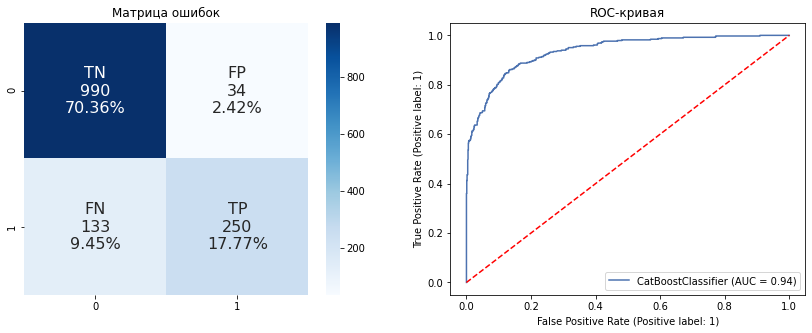

In [40]:
score_output(catboost_gs, fit=False)

- Мы видим что 88 % из предсказанных клиентов склонны к оттоку
- Мы можем распознать 65.3 % ушедших клиентов 
- Так же получилось незначительно увеличить качество ROC AUC до 0.936

#### Вывод

Финальной моделью стала модель градиентного бустинга catboost. Обучение происходило на топ 5 параметрах по мнению shap на модели catboost. Наилучшего качества удалось добиться после поиска параметров по сетке. Лучшее качество модели на тестовой выборке ROC AUC = 0.936

### Предложения по скидкам и промокодам

После исследовательского анализа данных возникла идея повысить лояльность пользователей с помощью предложения более выгодных условий и промо-акций.
При изучении данных о распределении по типу платежа, мы выяснили, что медианные значения платежей с помесячной оплатой дороже ежегодных, а ежегодные дороже оплаты раз в два года.
Можно рассчитать разницу в ценах и предложить переход на оплату с более долгим сроком и данным дисконтом.

In [ ]:
def discont(row1, row2):
    median_sum = df_full.groupby(by='type').median()['monthly_charges']
    return round((median_sum[row1] - median_sum[row2] ) / median_sum[row1] * 100)

print(f'Скидка с перехода от помесячной оплаты к годовой {discont(0, 1)}%')
print(f'Скидка с перехода от ежегодной оплаты к оплате раз в два года {discont(1, 2)}%')
print(f'Скидка с перехода от ежемесячной оплаты к оплате раз в два года {discont(0, 2)}%')

Скидка с перехода от помесячной оплаты к годовой 6%
Скидка с перехода от ежегодной оплаты к оплате раз в два года 6%
Скидка с перехода от ежемесячной оплаты к оплате раз в два года 12%


У нас получилась скидка в 6% которую можно предложить клиенту с помесячной и годовой оплатой. Так же клиентам с помесячной оплатой можно предложить перейти на оплату раз в два года со скидкой 12%

В случае с оплатой раз в два года, а так же в случае отказа в переходе на другой тариф можно предложить промокоды на бесплатные периоды пользования дополнительными сервисами. В результате анализа мы выяснили, что продолжительность жизни клиентов с дополнительными сервисами выше чем без них.

### Вывод

В результате анализа мы выяснили ряд наблюдений:


В последние 4 месяца был активный рост числа новых клиентов и так же в это время начался отток. Предположение о том, что отток связан с текучкой новых клиентов не подтвердилось. Процент текучки новых клиентов чуть выше, но основная часть ушедших клиентов из числа старых. Это говорит о возможном ухудшении качества услуг(возможно в связи с большим притоком клиентов увеличились нагрузки на мощности компании). Так же это могут быть демпинговые ходы компаний конкурентов.


Одним из самых весомых показателях оттока является тип оплаты клиента. Подавляющее большинство ушедших клиентов пользовались помесячной оплатой. Так же срок жизни клиентов с помесячной оплатой на порядок ниже альтернативны. В 5 раз меньше чем у клиентов с ежегодной оплатой и в 7 раз меньше чем у клиентов с оплатой раз в 2 года! Так же немаловажным фактором является метод платежа. У клиентов с автоплатежами текучка намного меньше, а так же выше средние чеки и продолжительность жизни.


Наблюдается увеличенный отток клиентов без детей и не состоящих в браке, а так же пенсионеров. У пенсионеров судя по данным отток происходит в связи с естественными причинами.


Так же увеличенный отток наблюдается у клиентов без подключенных дополнительных услуг телефонии и интернета. Время жизни таких клиентов так же меньше. Стоит проводить информирование и привлечение клиентов к данным сервисам


Была построена модель градиентного бустинга CatBoost с наилучшим показателем:
* ROC-AUC : 0.936
* Accuracy : 0.881
* Precision (точность): 0.880
* Recall (полнота): 0.653


Так же были предложены скидки и промокоды на основе данных

### Отчет по решению

#### Отчет по пунктам плана
1. Изучить и предобработать данные. **Выполнено: проведен первичный анализ и предобработка данных**
2. Провести исследовательский анализ данных **Выполнено: проведен исследовательский анализ и сделаны выводы из полученной информации**
3. Создать и обучить модели: подготовить признаки, обучить несколько моделей, для лучших подобрать параметры по сетке **Выполнено: подобранны признаки и обучено несколько моделей. На лучшей модели проведен подбор параметров по сетке**
4. Протестировать модели: протестировать лучшие модели и выбрать лучшую для дальнейшего внедрения в прод **Выполнено: лучшая модель протестирована, получены итоговые метрики**
5. Сформировать рекомендации по внедрению промокодов на основе результатов **Выполнено: предложены рекомендации по скидкам и промокодам на основе полученных данных**

#### Возникшие трудности

Особых трудностей при работе с проектом не возникло, за исключением того, что сложно давать экономически обоснованные рекомендации по скидкам, не зная себестоимости продукта.

#### Ключевые шаги проекта

* Предобработка данных
* Изучение проблематики бизнеса из полученных данных
* Построение пайплайнов
* Отбор и обучение моделей
* Анализ моделей по метрикам
* Попытки улучшить модель подбором фич и параметров модели
* Выводы

#### Итоговая модель

CatBoost с метриками:
* ROC-AUC : 0.936
* Accuracy : 0.881
* Precision (точность): 0.880
* Recall (полнота): 0.653